In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import itertools
from itertools import combinations

def main():
    todays_players = [40,6,23,26,15,98,1,10,55,16,
                      56,97,96,12,13,41,52,88,66,94,
                      89,86,87,77,79,72,76]
    input_data = pd.read_csv('MahjongScores.csv')

    pairings_df = create_pairings_table(todays_players)
    matchups_df = create_freq_matchups(pairings_df, input_data)
    
    table_info = get_table_info(todays_players)
    
    output_tables = generate_tables(table_info, matchups_df)
    
    print output_tables

In [2]:
def create_pairings_table(todays_players):
    # Create a zeros DataFrame of (#players,#players) size for matchups, with ordered indices.
    num_players = len(todays_players)
    pairings_df = DataFrame(np.zeros(num_players**2).reshape(num_players,num_players))
    pairings_df.index = sorted(todays_players)
    pairings_df.columns = sorted(todays_players)
    return pairings_df

In [3]:
def get_player_data(input_data, todays_players):
    # Reduce input_data to only the rows relevant to today's players
    games_rows = pd.DataFrame()
    for i in todays_players:
        games_rows = games_rows.append(input_data.loc[(input_data['PlayerId'] == i)])
    return games_rows

In [4]:
def create_freq_matchups(pairings_df, input_data):
    # Grab today's players and initialize output df
    todays_players = pairings_df.columns
    matchups_df = pairings_df.copy()
        
    # Pull all rows from input_data relevant to today's players
    games_rows = get_player_data(input_data, todays_players)
    
    # Make a list of unique games
    uniquegames = games_rows['GameId'].unique()
        
    # Get all players in each relevant game and populate matchup table one game at a time
    for gameid in uniquegames:
        gameid_players = []
        gameid_rows = games_rows.loc[(games_rows['GameId'] == gameid)] # Pull only the rows for players in that game
        gameid_players = gameid_rows['PlayerId'].tolist() #Give each player an index
        for i in range( len(gameid_players)): # For each player in a game
            for j in range( len(gameid_players)): 
                matchups_df.at[gameid_players[i],gameid_players[j]] += 1 # Add a game in opponent's column
    
    # Diagonal values are total # of games played for that player
    return matchups_df  

In [5]:
def create_score_matchups(pairings_df, input_data):
    todays_players = pairings_df.columns
    games_rows = get_player_data(input_data, todays_players)
    matchups_df = pairings_df.copy()
    
    for gameid in games_rows['GameId'].unique():
        # Pull rows for one game at a time
        gameid_players = []
        gameid_rows = games_rows.loc[(games_rows['GameId'] == gameid)]

        # Paired scores and players have the same index
        gameid_players = gameid_rows['PlayerId'].tolist()
        gameid_scores = gameid_rows['Score'].tolist()

        for i in range( len(gameid_players)): # For each player in that game
            flag = False
            for j in range( len(gameid_players)): # Get all players (including self)
                # Don't add along diagonal more than once for each player
                if (i == j):
                    if flag == False: 
                        matchups_df.at[gameid_players[i],gameid_players[j]] += gameid_scores[i]
                    flag = True
                else:
                    matchups_df.at[gameid_players[i],gameid_players[j]] += gameid_scores[i] # Add score of i to matchup sum
    
    freq_df = create_freq_matchups(pairings_df, input_data)
    for i in range( len(todays_players)):
        for j in range( len(todays_players)):
            matchups_df.iat[i,j] = matchups_df.iat[i,j] / np.diagonal(freq_df)[j]
    
    # Diagonal values are player's average score            
    return matchups_df

In [6]:
def get_table_counts(todays_players):
    # Determine amount of 5 person tables
    if len(todays_players) < 8:
        total_tables = 1
        if len(todays_players) == 4:
            tables_4p = 1
            tables_5p = 0
        elif len(todays_players) == 5:
            tables_4p = 0
            tables_5p = 1
        else:
            tables_4p = tables_5p = 0
    else:
        tables_5p = len(todays_players) % 4
        total_tables = int( len(todays_players) / 4)
        tables_4p = total_tables - tables_5p
    
    table_counts = [total_tables, tables_4p, tables_5p]
    
    return table_counts

In [7]:
def sum_ratings(table_players, matchups_df):
    table_sum = 0
    for i in table_players:
        for j in table_players:
            if i>j: # This only serves to prevent repeats
                table_sum += max(matchups_df.at[i,j],matchups_df.at[j,i])
    return table_sum

In [8]:
def generate_tables(table_types, matchups_df):
    output_tables = []
    total_tables = table_counts[0]
    tables_4p = table_counts[1]
    tables_5p = table_counts[2]
    tables_5p_made = 0
    temp_playerlist = list(matchups_df.columns) # Make a copy of today's players to modify
    
    # Make tables until all tables are made
    while len(output_tables) < total_tables:
    
        # Make final table if only 4 players are in pool
        if (len(temp_playerlist) == 4):
            output_tables.append(tuple(temp_playerlist))
            break
    
        # Generate list of combinations for table size
        if tables_5p_made < tables_5p:
            table_combs = list(itertools.combinations(temp_playerlist,5))
            tables_5p_made += 1
        else:
            table_combs = list(itertools.combinations(temp_playerlist,4))

        # Calculate matchmaking rating for each table (lower means players have fewer games together)
        table_df = DataFrame(table_combs)
        table_sums = table_df.apply(sum_ratings, args=[matchups_df], axis=1)    
       
        # Take first minimum value in table_sums - gives priority to lower PlayerId
        best_table_ix = np.argmin(table_sums)
        print table_sums[best_table_ix]
        output_tables.append(table_combs[best_table_ix])
    
        # Remove players that have already been seated from the pool
        for player in table_combs[best_table_ix]:
            temp_playerlist.remove(player)
    return output_tables

#Data visualization example with Mahjong Matchmaking Toolkit (MMT)
#####Note: This library uses the following release versions:
* [Python 2.7.2](https://www.python.org/download/releases/2.7.2/)
* [Numpy 1.9.2](http://www.scipy.org/scipylib/download.html)
* [Pandas 0.16.2](http://pypi.python.org/pypi/pandas/0.16.2/#downloads)

One of many ways that MMT can make life easier for mahjong group coordinators is visualizing different aspects of the group. In this quick example, we will use MMT in conjunction with the [`matplotlib 1.4.3`](http://matplotlib.org/) and [`seaborn 0.6.0`](http://stanford.edu/~mwaskom/software/seaborn/) Python visualization libraries to see whether some players have winning or losing tendencies at a glance.

Now, imagine being at the end of a long night of mahjong; 27 people showed up to play, and you simply want to take a look at how these people are doing against each other, without regard to players who didn't come today. We can accomplish this quickly by plotting a [**heatmap of player matchup scores**](#Plotting-the-heatmap) and a [**bar chart with each player's average rank**](#Plotting-the-bar-chart).

####Supply input data 
First, let's make a `list` of players by using the ID numbers that each person was assigned when they joined our mahjong group. Because everyone was assigned a unique ID number, our schema fits perfectly into MMT's allowed `list` inputs for players:

In [20]:
todays_players = [40,6,23,26,97,98,1,10,55,16,
                  56,90,96,12,13,41,52,88,66,94,
                  89,86,87,77,79,72,76]
print len(todays_players)

27


Next, we'll need to import our data. Pandas has multiple methods of importing to `DataFrame` objects, and while we import a `.csv` here, data can just as easily be pulled from a SQL query, from a saved Excel spreadsheet, or even from a dynamic online spreadsheet that gets populated by a form. Here, we import data for our mahjong play group from a `.csv` file that we created earlier, and assign it directly to a pandas `DataFrame` object with `pd.read_csv`. 

In [25]:
input_data = pd.read_csv('MahjongScores.csv')

To preview our data, we can call the pandas [`DataFrame.head()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html#pandas.DataFrame.head) method. When called with no arguments, it will return the first 5 rows:

In [24]:
input_data.head()

   ScoreId  GameId  PlayerId  Rank  RawScore  Score  Unnamed: 6
0        1       1        23     1         0     38         NaN
1        2       1        52     2         0     13         NaN
2        3       1         6     3         0     -9         NaN
3        4       1        98     4         0    -42         NaN
4        5       2         6     1         0     30         NaN


Here we see that both the required columns `GameId` and `PlayerId` are present in `input_data`. As a result, we can continue without needing to change the format of the `DataFrame`.
 
For the purpose of this visualization example, we import the `matplotlib` and `seaborn` libraries. This will allow us to plot the heatmap and bar chart:

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Call inline to view our plots directly
%matplotlib inline

####Generate matchup tables

Since our first task is to produce a heatmap of matchup scores, we would like to make the matchups table via `create_score_matchups()`. This function takes two inputs: the first is a pairings `DataFrame` which we can generate with `create_pairings_table()`, and the second is our historical data, which we have already stored in `input_data`. Here, we store the pairings `DataFrame` as `pairings_df`:

In [26]:
pairings_df = create_pairings_table(todays_players)
pairings_df.head()

,1,6,10,12,13,16,23,26,40,41,...,79,86,87,88,89,90,94,96,97,98
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we'll store the result of calling `create_score_matchups()` with our newly made pairings `DataFrame` as an input:

In [13]:
score_matchups = create_score_matchups(pairings_df, input_data)
score_matchups.head()

,1,6,10,12,13,16,23,26,40,41,...,79,86,87,88,89,90,94,96,97,98
1,-4.909091,-0.455882,2.363636,0.406250,0.000000,0.000000,0.000,0,0,0,...,0,0.0,0.000000,0,0.000000,0.000000,0,0,0,-0.030675
6,1.454545,6.470588,0.000000,0.812500,1.178571,-5.666667,-0.120,0,0,0,...,0,0.0,0.000000,0,2.583333,4.277778,0,0,0,0.079755
10,-1.000000,0.000000,-0.090909,-0.171875,0.000000,0.000000,-0.328,0,0,0,...,0,1.6,-12.333333,0,0.000000,0.000000,0,0,0,-0.165644
12,-2.636364,-1.514706,-2.636364,-9.625000,-2.678571,0.000000,-2.992,0,0,0,...,0,6.3,0.000000,8,0.583333,0.000000,0,0,0,-1.668712
13,0.000000,-0.705882,0.000000,1.187500,6.821429,2.333333,-0.120,0,0,0,...,0,3.9,0.000000,0,0.000000,-2.666667,0,0,0,0.337423


####Plotting the heatmap
At this point, we're ready to plot our heatmap, and all that's needed is formatting for the plot itself. Since we're looking at positive and negative scores, it makes sense to use a [diverging color palette](http://stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html?highlight=diverging%20palette). While these are customizable, we will just use a blue-white-red colormap that is already included in the seaborn library. To plot the actual heatmap, we call [`sns.heatmap()`](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html) using `score_matchups` as the data, and use a few other arguments such as to make the heatmap a bit cleaner:

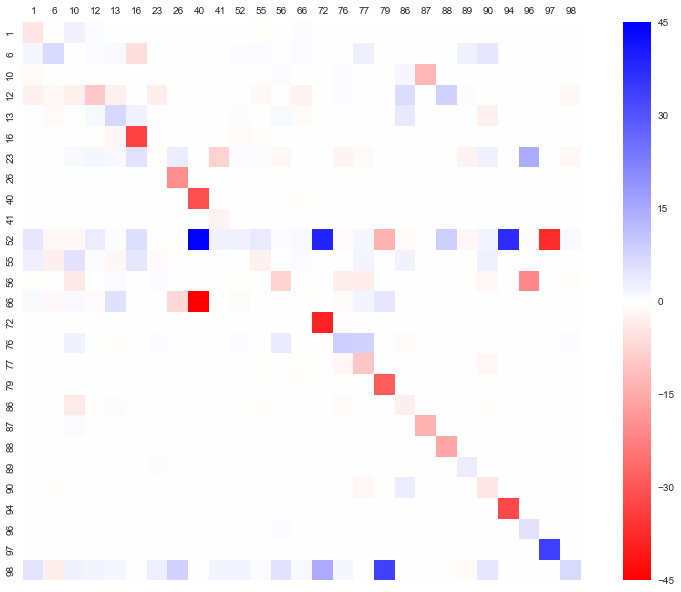

In [31]:
# Plot a heatmap of matchups, where diagonal is player personal average
plt.figure(figsize=(15,10))
ax = sns.heatmap(score_matchups, cmap='bwr_r', square=True, vmin=-45, vmax=45)
ax.xaxis.tick_top()

You can see here that player 52 tends to do well against players 40, 72, and 94, but poorly against players 79 and 97. In this heatmap, we can also qualitatively gauge each player's personal average score by looking at whether their position on the diagonal is blue or red. As a result, we can see that player 97 has the highest average score of everybody in today's player pool. While this might otherwise take some time to determine, MMT makes the data extraction easy. 

####Getting a subset of player data
Next, we'll work on making our bar chart of average rank. For this, we're going to have average rank as the y-axis, and `PlayerId` as the x-axis. To put our data into this format, we'll do some straightforward manipulation of our input data. To begin with, let's call `get_player_data()` to reduce our input data to only the players from tonight:

In [16]:
players_data = get_player_data(input_data, todays_players)
players_data.head()

,ScoreId,GameId,PlayerId,Rank,RawScore,Score,Unnamed: 6
647,648,150,40,4,0,-31,NaN
2,3,1,6,3,0,-9,NaN
4,5,2,6,1,0,30,NaN
9,10,3,6,2,0,14,NaN
15,16,4,6,4,0,-29,NaN


Since we want to get aggregate data (e.g. mean, standard deviation) on each player's ranking history, we can simplify the task by using [`DataFrame.groupby()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html). Here, we group the `Rank` data by `GameId` and `PlayerId`. This allows us to later access `Rank` values by supplying the `(GameId, PlayerId)` tuple.

In [17]:
# Group games_rows by GameId and PlayerId to access multiple row values at once
grouped_ranks = players_data['Rank'].groupby([players_data['GameId'], players_data['PlayerId']])

Next, we'll initialize a `DataFrame` to store this data in a more readable format. We want our `DataFrame` to have all player `Rank` values in one row for each unique `GameId`. Here, we initialize the `DataFrame` with null values instead of zeros so that our aggregate data isn't affected:

In [18]:
ranks_table = DataFrame()
ranks_table['GameId'] = np.sort(players_data['GameId'].unique()) # Create a GameId column with only one of each Id

# Create a new column for each player
for playerid in todays_players: 
    ranks_table[playerid] = np.nan 
ranks_table.head()

,GameId,40,6,23,26,97,98,1,10,55,...,88,66,94,89,86,87,77,79,72,76
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll then populate these columns with each player's scores, using the `groupby` object `grouped_ranks` we made earlier. Here, we iterate through each combination of the tuple `(game, player)` and take the corresponding `rank` value. The value is then assigned to the row-column pair that corresponds to the tuple:

In [19]:
# Populate columns with each player's scores
for (game, player), rank in grouped_ranks:
    ranks_table.loc[ranks_table['GameId'] == game, player] = rank.iloc[0]
ranks_table.head()

,GameId,40,6,23,26,97,98,1,10,55,...,88,66,94,89,86,87,77,79,72,76
0,1,NaN,3,1,NaN,NaN,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,2,NaN,NaN,NaN,3,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,4,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,3,2,NaN,NaN,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


####Obtaining aggregate data
From here, we can use the [`DataFrame.describe()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html?highlight=describe#pandas.DataFrame.describe) function to generate aggregate data for each of our players. Because the pandas `DataFrame` object does not have a one-step method for sorting based on values in rows, we then transpose it to simplify the sorting process:

In [20]:
rank_info = ranks_table.describe().transpose()
rank_info.head()

,count,mean,std,min,25%,50%,75%,max
GameId,504,276.972222,169.509699,1,127.75,266.5,426.50,585
40,1,4.000000,NaN,4,4.00,4.0,4.00,4
6,68,2.411765,1.260600,1,1.00,2.0,3.25,5
23,125,2.696000,1.130401,1,2.00,3.0,4.00,5
26,4,3.500000,0.577350,3,3.00,3.5,4.00,4


####Plotting the bar chart
Now that we are close to making our plot, we'll remove the `GameId` row and sort our `DataFrame` by the values of `'mean'` for visual clarity. Also, we'll only keep the columns that contain the mean and the standard deviation:

In [21]:
rank_info.drop('GameId', inplace=True)
rank_info.sort(columns='mean', inplace=True)
rank_info = rank_info[['mean','std']]

At this point, all that remains is the plotting itself. We'll use [`matplotlib.pyplot.plot()`](http://matplotlib.org/api/pyplot_api.html) to draw each player's average rank in a bar chart, and use the error bars argument to draw our standard deviations:

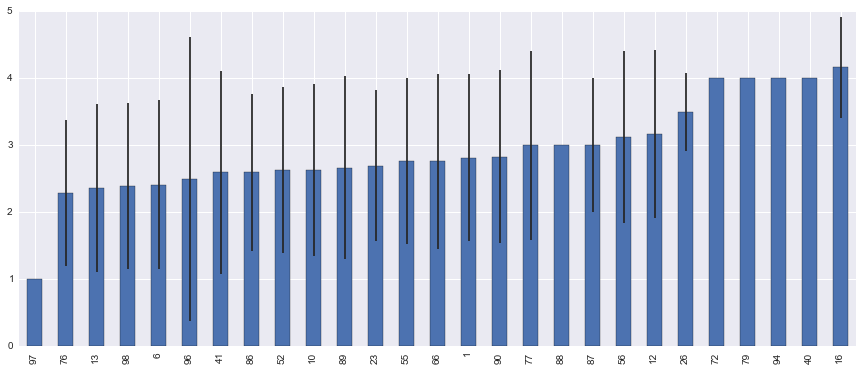

In [23]:
rank_info['mean'].plot(yerr=rank_info['std'], kind='bar', figsize=(15,6))

For players in our group that have played more than one game (ones with error bars), we see that player 76 has had the highest average rank. By using MMT to manipulate player data and to help create visualizations, we find evidence that differences in skill exist within the group.